In [5]:
from typing import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

46
<BarContainer object of 46 artists>


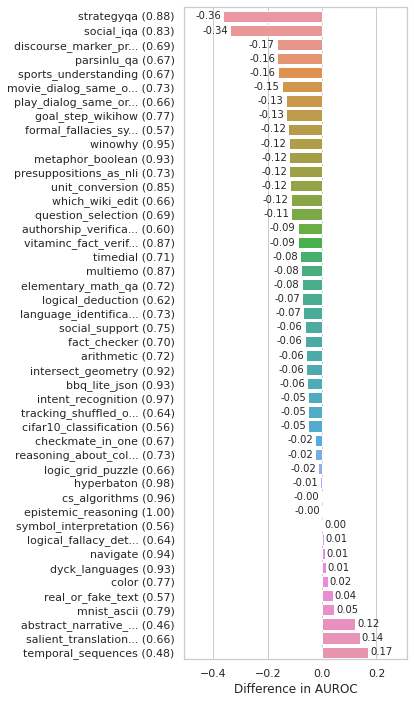

In [6]:
def prepare(df: pd.DataFrame):
    df = df.rename(columns={df.columns[0]: 'task'})
    df = df[df['test_conf_normalized_roc_auc'] > 0.1]
    df = df[df['count'] > 100]
    df = df.sort_values(by='task')
    df = df.reset_index(drop=True)
    return df


tsa = pd.read_csv('../artifacts/csv-results/task-specific-assessors.csv')
ref = pd.read_csv('../artifacts/csv-results/scaling-0sh/128b.csv')
tsa = prepare(tsa)
ref = prepare(ref)
ref = ref.loc[ref['task'].isin(tsa['task'])]
ref = ref.reset_index(drop=True)

assert all(tsa.task == ref.task)

Baseline = Literal['normalized', 'absolute', 'distribution']

def shorten(x, length=15):
    if len(x) > length:
        return x[:length-3] + "..."
    else:
        return x

def plot(tla: pd.DataFrame, ref: pd.DataFrame, baseline: Baseline = "normalized", metric: str = "roc_auc"):
    sns.set_theme(style="whitegrid")
    task_system_col = f"test_conf_{baseline}_{metric}"
    assessor_col = f"test_{metric}"

    data = pd.DataFrame()
    data['task'] = tla['task']
    data['count'] = tla['count']
    data['diff'] = tla[assessor_col] - ref[assessor_col]
    data['ref'] = ref[assessor_col]
    data['tla'] = tla[assessor_col]

    data.sort_values(by="diff", inplace=True)
    print(len(data))

    y = data.apply(lambda x: f"{shorten(x['task'], length=22)} ({x['ref']:.2f})", axis=1)

    total = data[data['task'] == '_total']
    data = data[data['task'] != '_total']
    data = pd.concat([data, total])

    plt.figure(figsize=(4,12))
    
    p = sns.barplot(y=y, x="diff", data=data, orient='h')

    for i in p.containers:
        print(i)
        p.bar_label(i,fmt='%.2f', label_type='edge', padding=2)
    p.set_xlim(p.get_xlim()[0]*1.3, p.get_xlim()[1]*1.6)
    p.set_ylim(p.get_ylim()[0]*1.0, p.get_ylim()[1]*1.3)

    p.set_xlabel("Difference in AUROC")
    plt.savefig(f'../artifacts/plots/tsa.svg', bbox_inches='tight', format='svg')

#     # return data

plot(tsa, ref, metric="roc_auc")